In [115]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

In [116]:
# Define the base path
base_path = Path("OneDrive_1_28-01-2026")

# Get all CAT folders
csv_files = sorted(base_path.glob("CAT*"))

# Dictionary to store dataframes from each CAT folder
data_dict = {}

# Read each CSV file
for csv_file in csv_files:
    file_name = csv_file.stem  # filename without extension
    
    try:
        # Skip first 2 rows (Patient report and CAT ID), row 3 is the header
        df = pd.read_csv(csv_file, skiprows=2)
        
        # Convert timestamp to datetime
        df['Device Timestamp'] = pd.to_datetime(df['Device Timestamp'], format='%d-%m-%Y %H:%M')
        
        data_dict[file_name] = df
        print(f"✓ Loaded {csv_file.name}")
    except Exception as e:
        print(f"✗ Error loading {csv_file.name}: {e}")

# Now you can access like:
# data_dict['CAT01WELLCOME_glucose_10-8-2023']
print(f"\nTotal files loaded: {len(data_dict)}")
print(f"Available keys: {list(data_dict.keys())[:5]}")  # Show first 5

# View first few rows of one file
if data_dict:
    first_key = list(data_dict.keys())[0]
    print(f"\nPreview of {first_key}:")
    print(data_dict[first_key].head())

✓ Loaded CAT01WELLCOME_glucose_10-8-2023.csv
✓ Loaded CAT02WELLCOME_glucose_29-9-2023.csv
✓ Loaded CAT03WELLCOME_glucose_29-9-2023.csv
✓ Loaded CAT04Wellcome_glucose_29-9-2023.csv
✓ Loaded CAT05WELLCOME_glucose_20-10-2023.csv
✓ Loaded CAT06WELLCOME_glucose_30-11-2023.csv
✓ Loaded CAT07-01WELLCOME_glucose_12-1-2024.csv
✓ Loaded CAT10Wellcome_glucose_16-2-2024.csv
✓ Loaded CAT11WELLCOME_glucose_26-2-2024.csv
✓ Loaded CAT12WELLCOME_glucose_15-3-2024.csv
✓ Loaded CAT13WELLCOME_glucose_21-3-2024.csv
✓ Loaded CAT14WELLCOME_glucose_17-4-2024.csv
✓ Loaded CAT15Wellcome_glucose_10-5-2024.csv
✓ Loaded CAT17WELLCOME_glucose_15-1-2025.csv
✓ Loaded CAT18WELLCOME_glucose_14-11-2024.csv
✓ Loaded CAT19WELLCOME_glucose_15-1-2025.csv
✓ Loaded CAT20WELLCOME_glucose_15-1-2025.csv
✓ Loaded CAT21WELLCOME_glucose_28-1-2025.csv

Total files loaded: 18
Available keys: ['CAT01WELLCOME_glucose_10-8-2023', 'CAT02WELLCOME_glucose_29-9-2023', 'CAT03WELLCOME_glucose_29-9-2023', 'CAT04Wellcome_glucose_29-9-2023', 'CA

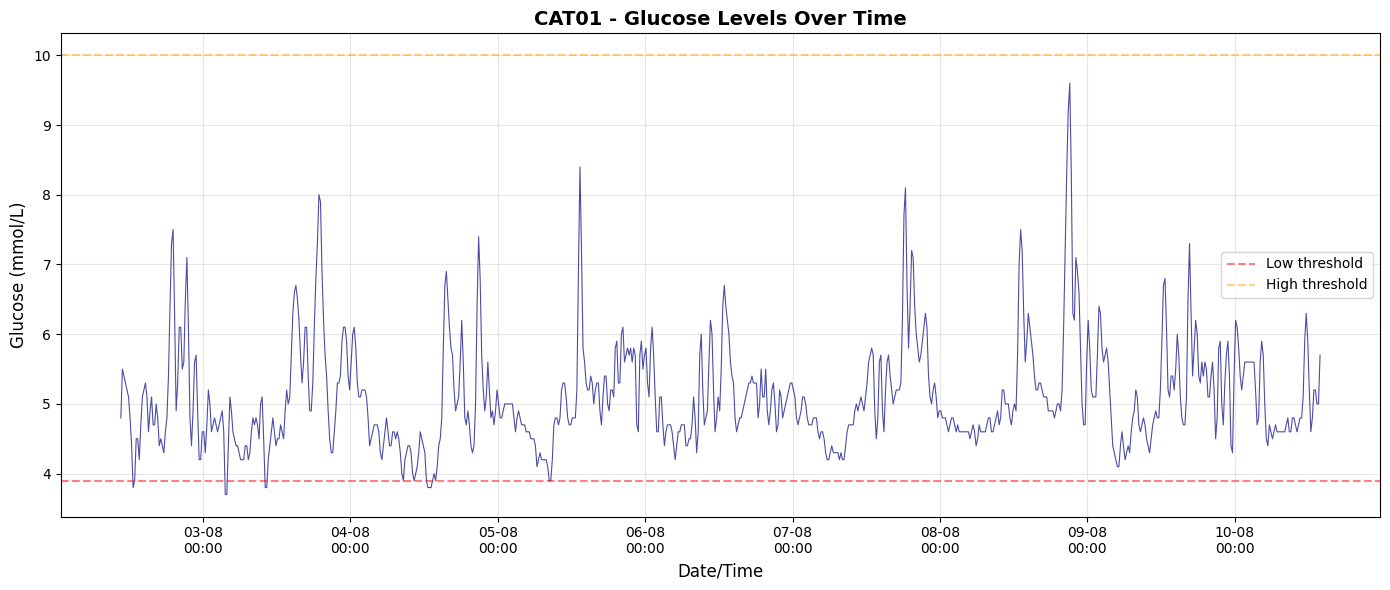

Plotted CAT01


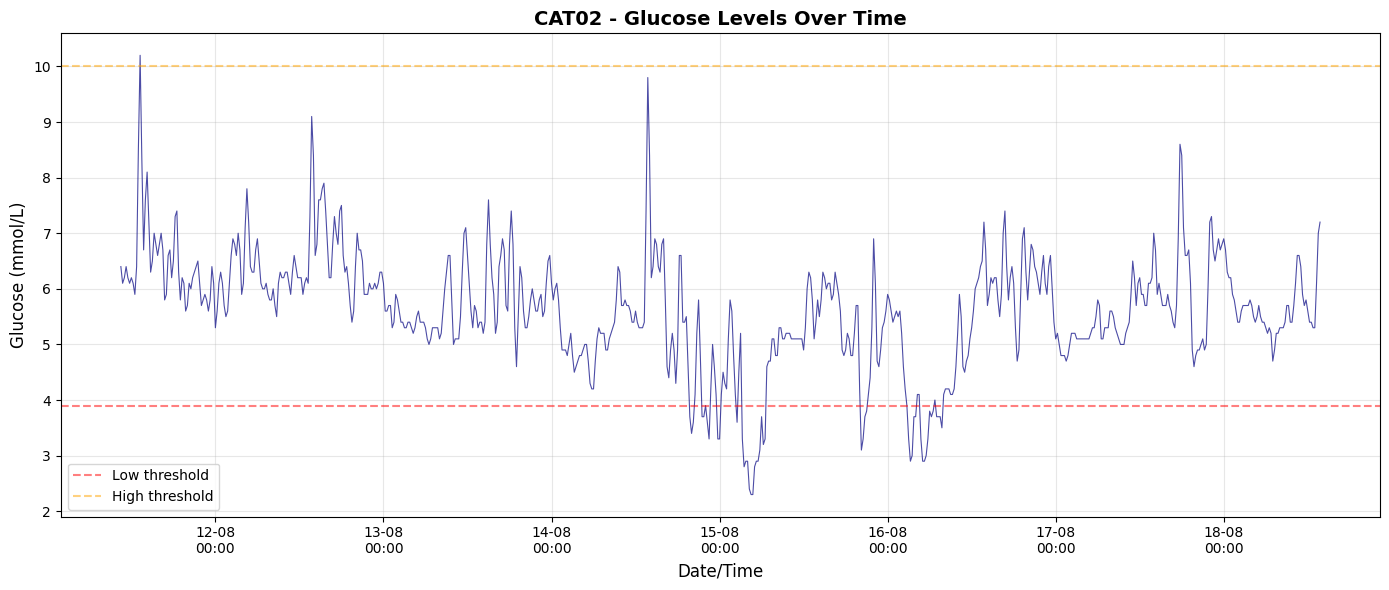

Plotted CAT02


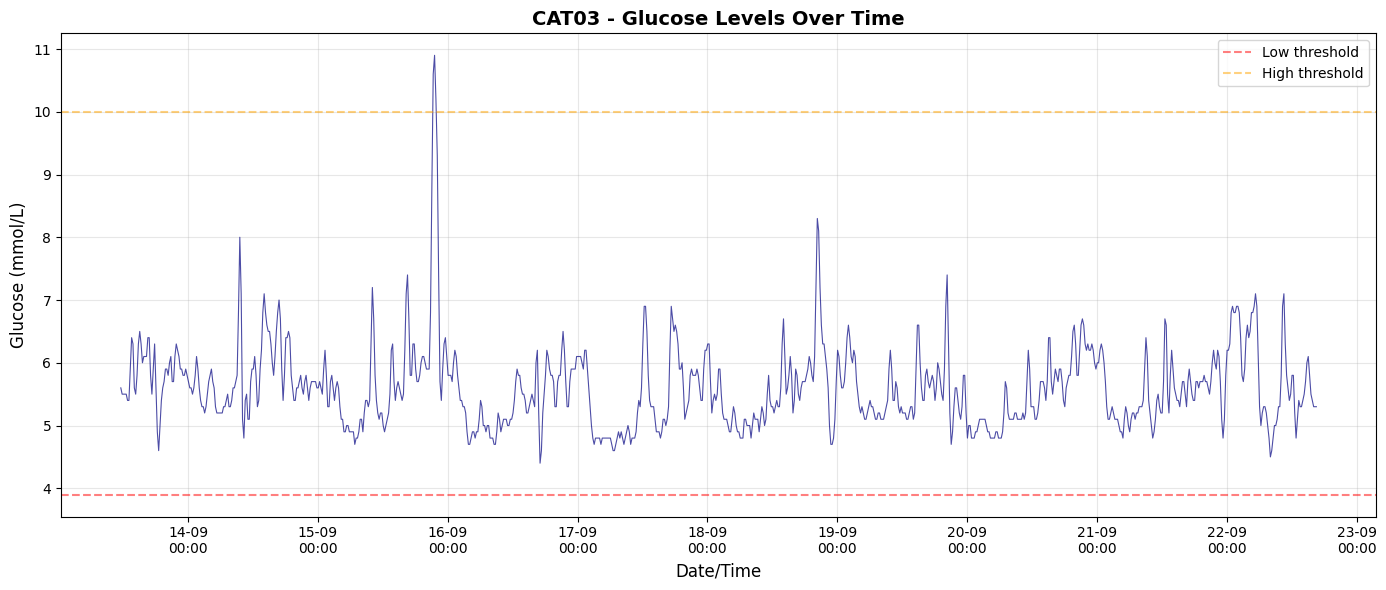

Plotted CAT03


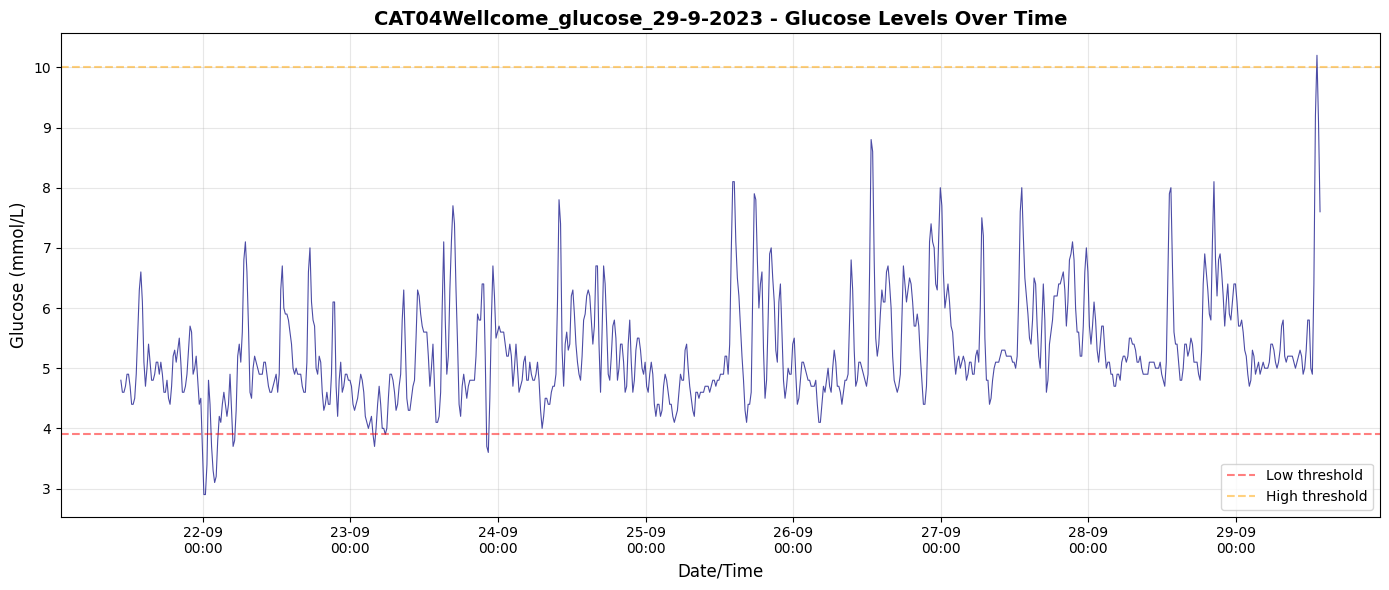

Plotted CAT04Wellcome_glucose_29-9-2023


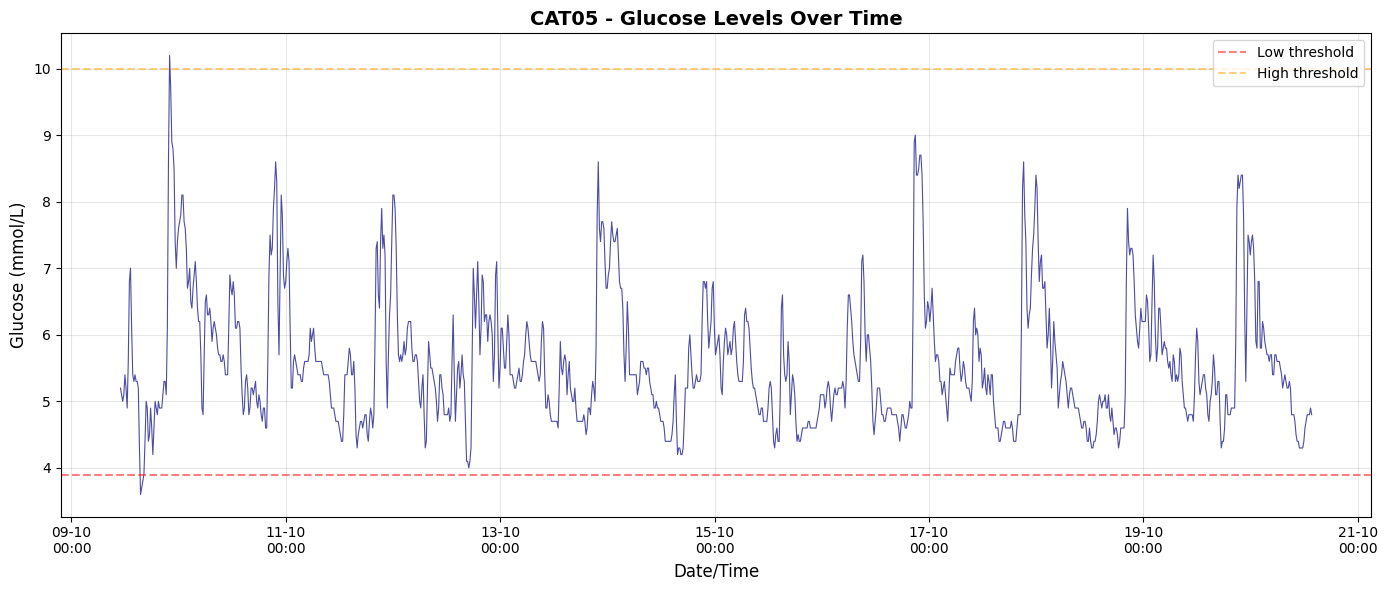

Plotted CAT05


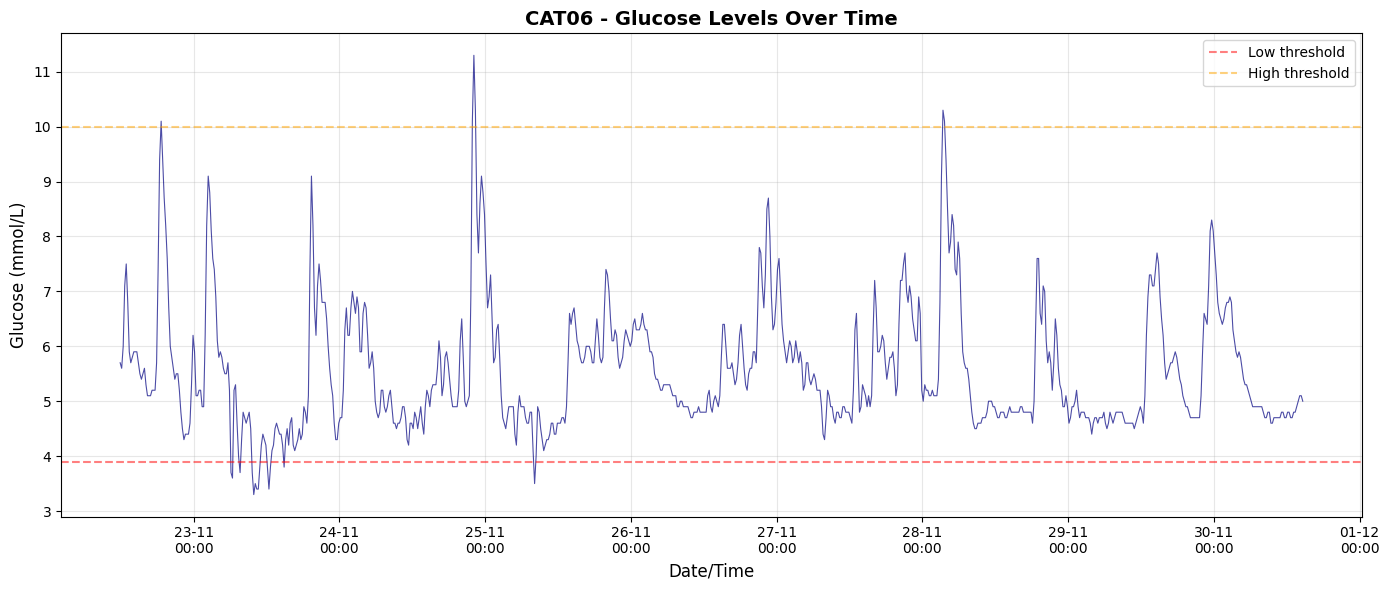

Plotted CAT06


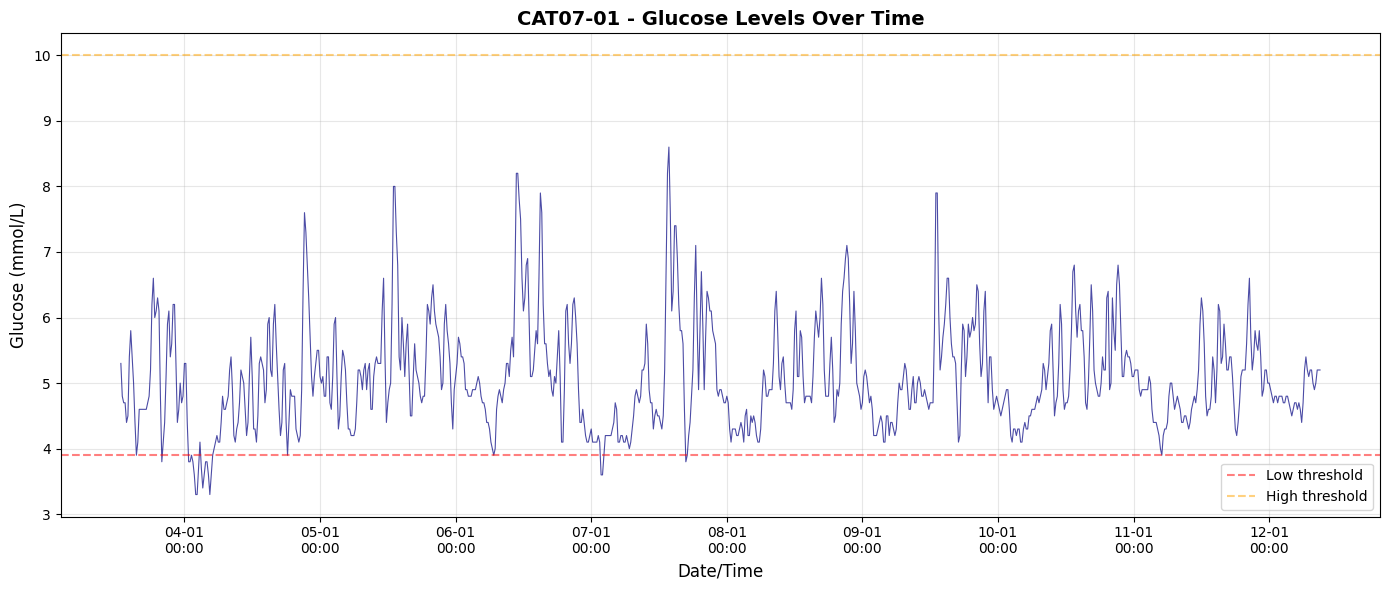

Plotted CAT07-01


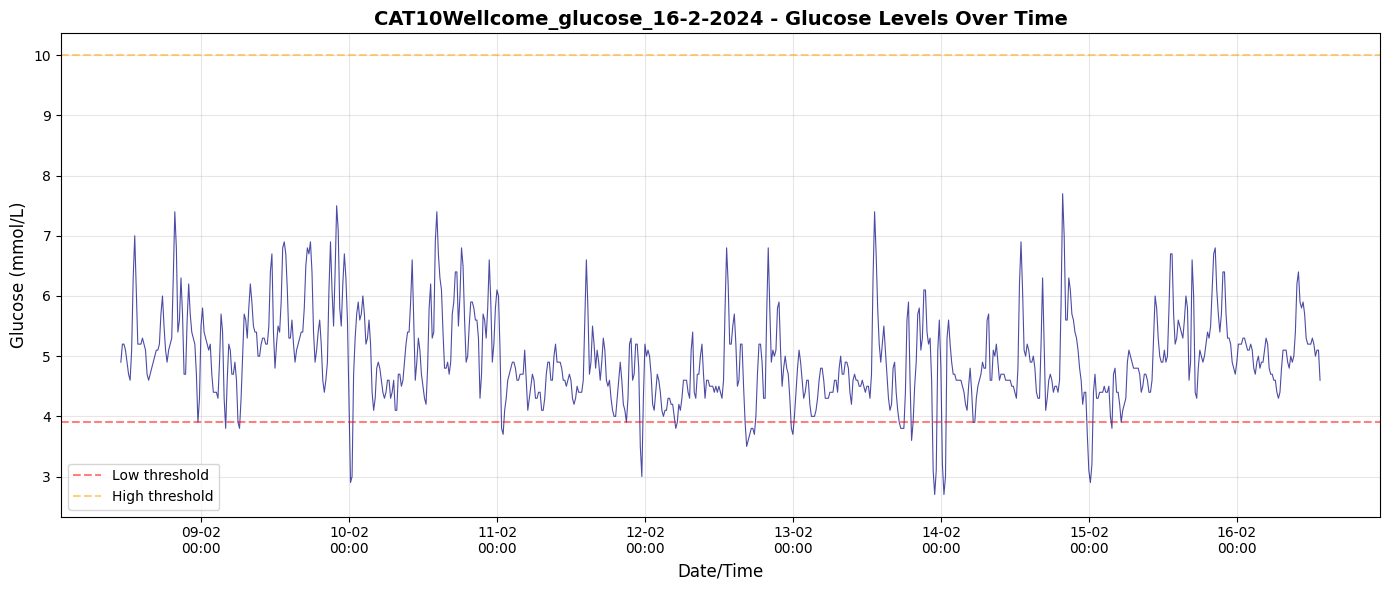

Plotted CAT10Wellcome_glucose_16-2-2024


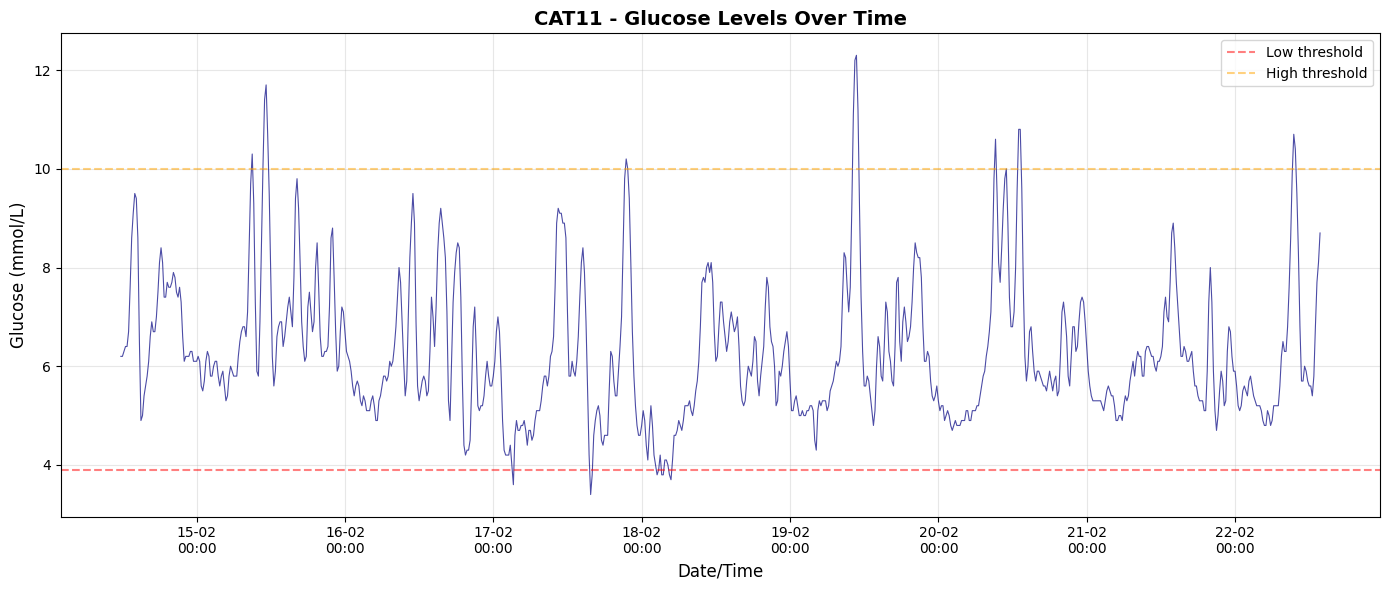

Plotted CAT11


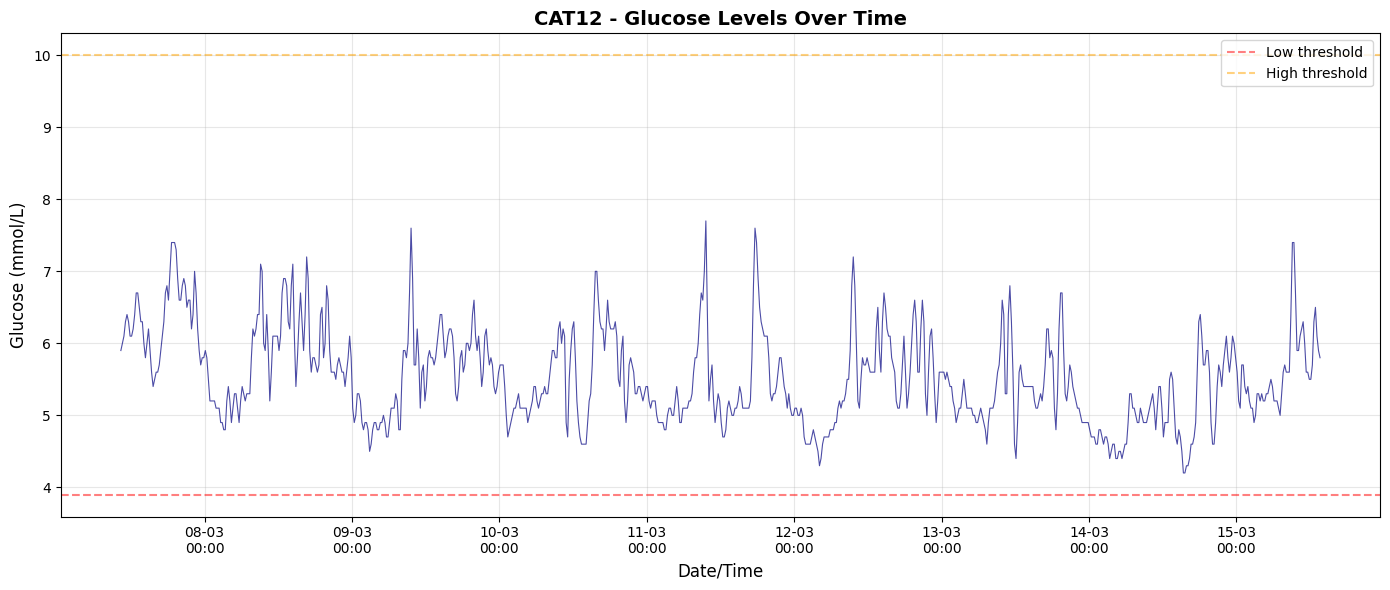

Plotted CAT12


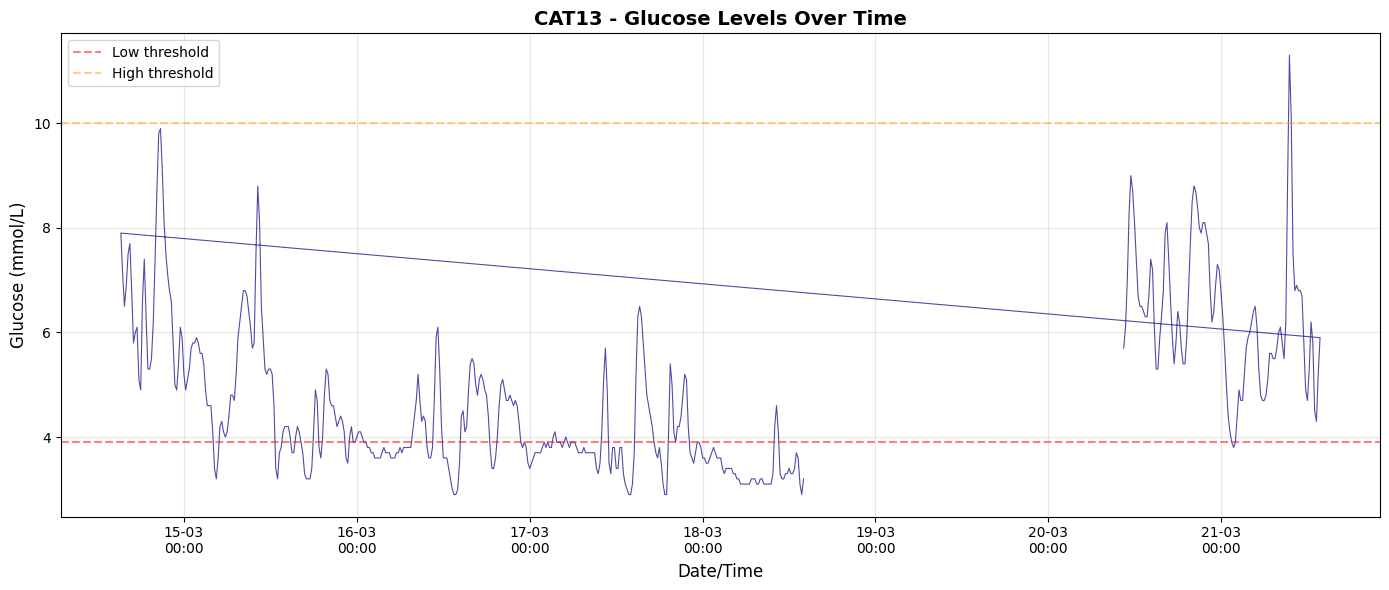

Plotted CAT13


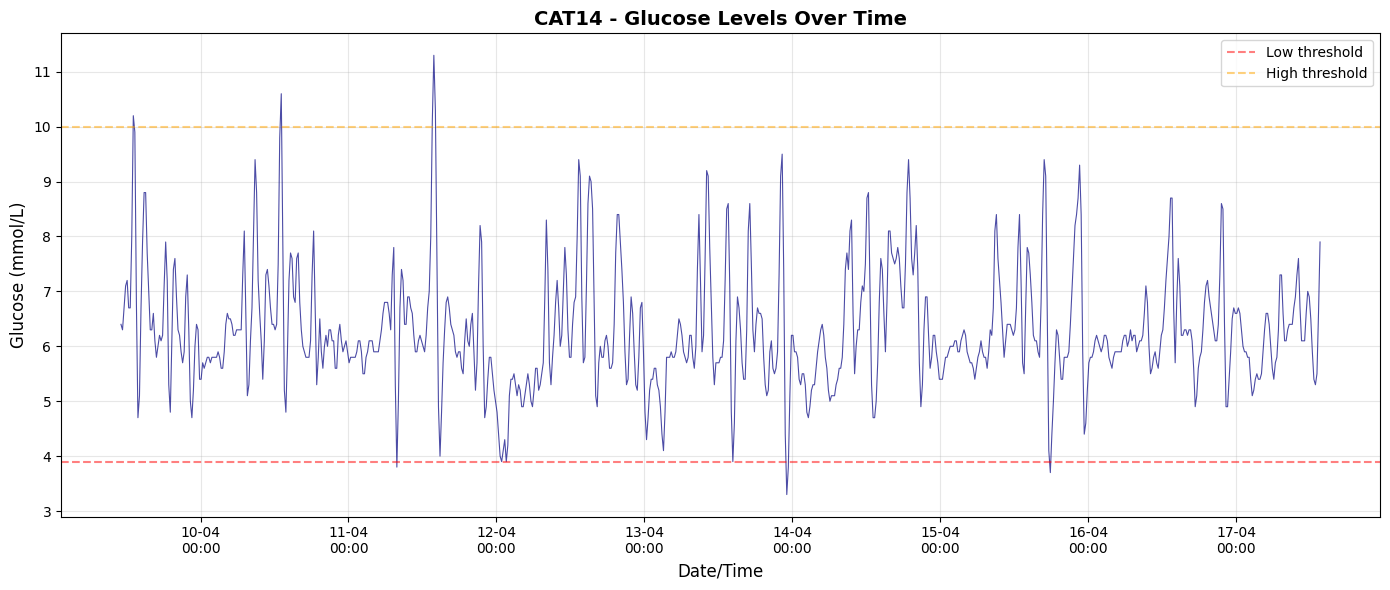

Plotted CAT14


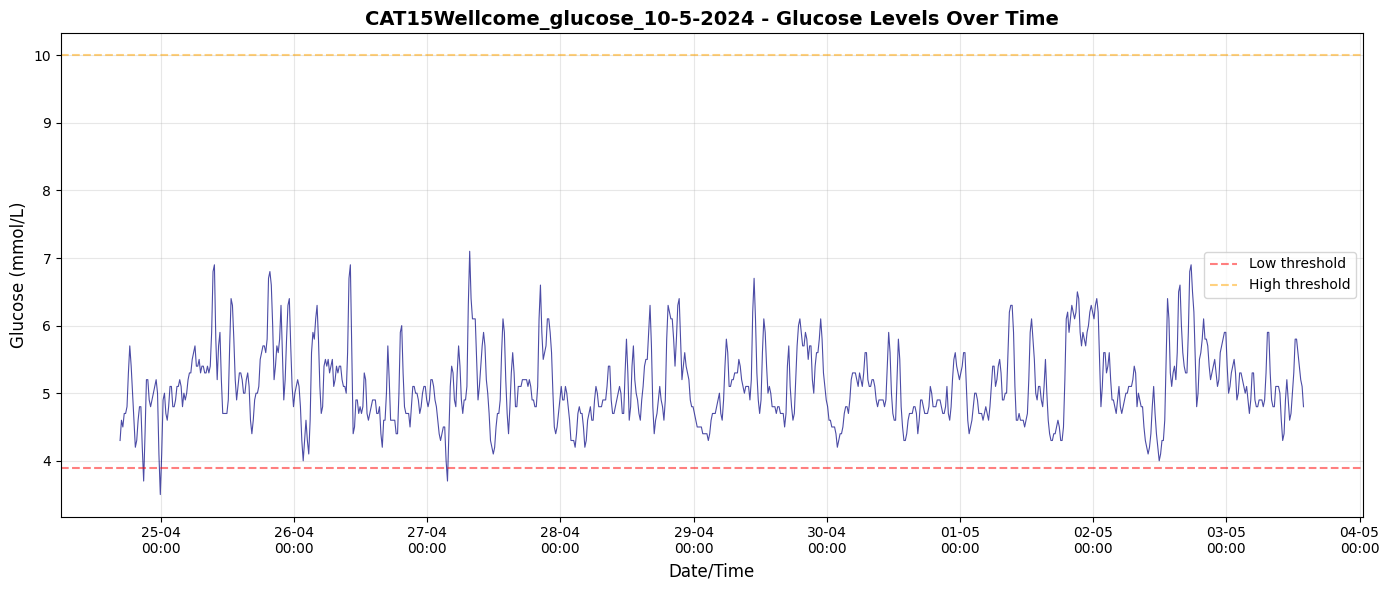

Plotted CAT15Wellcome_glucose_10-5-2024


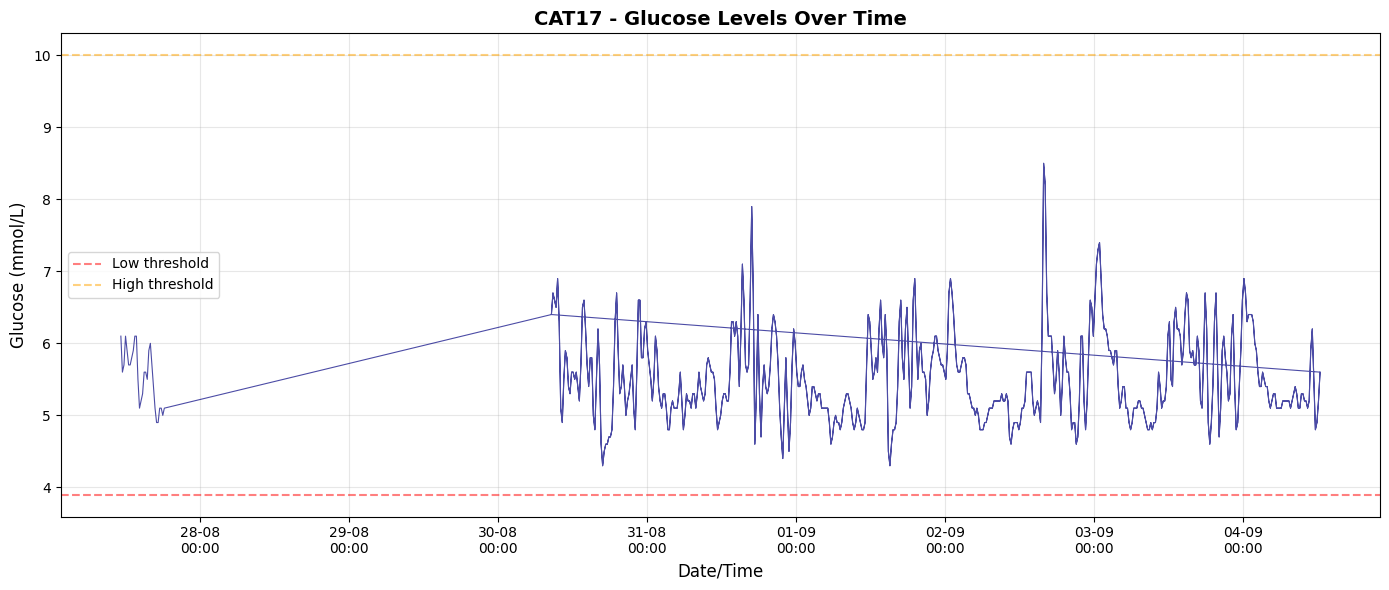

Plotted CAT17


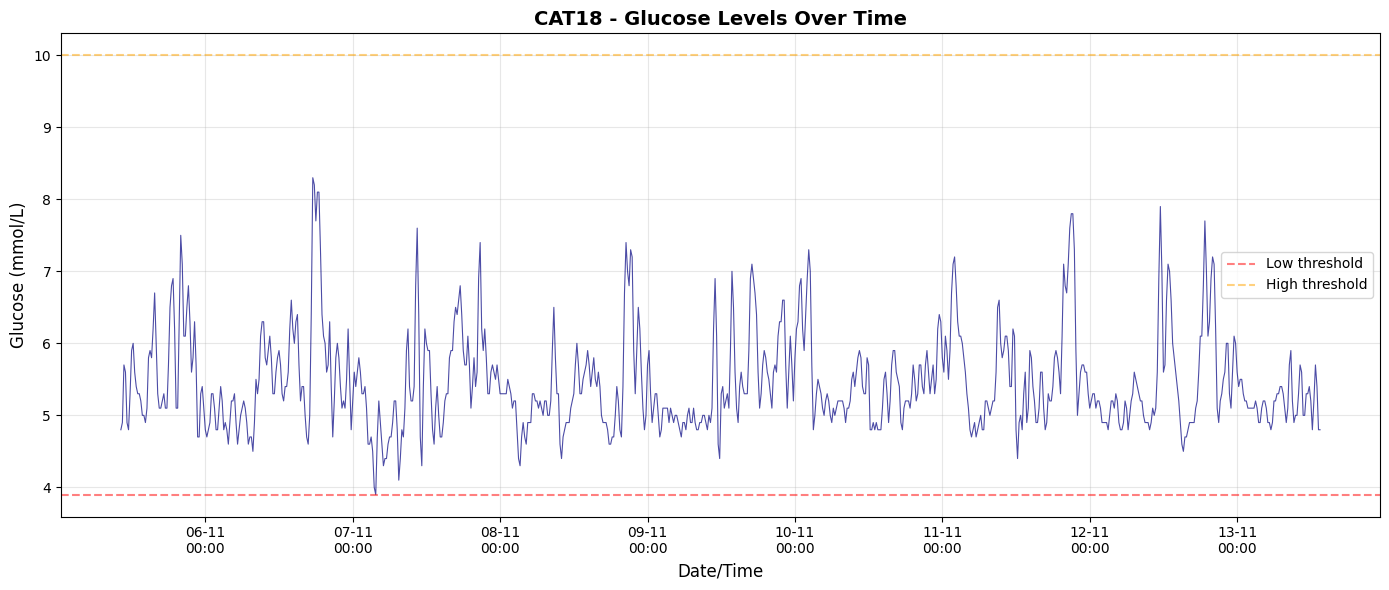

Plotted CAT18


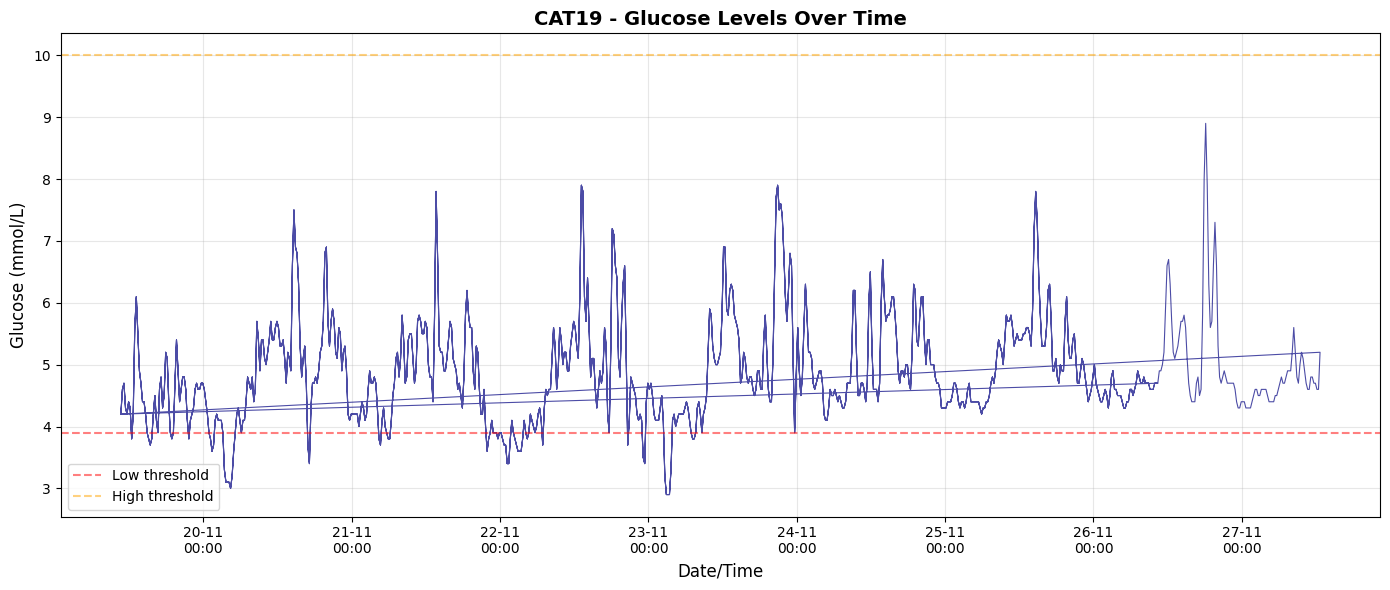

Plotted CAT19


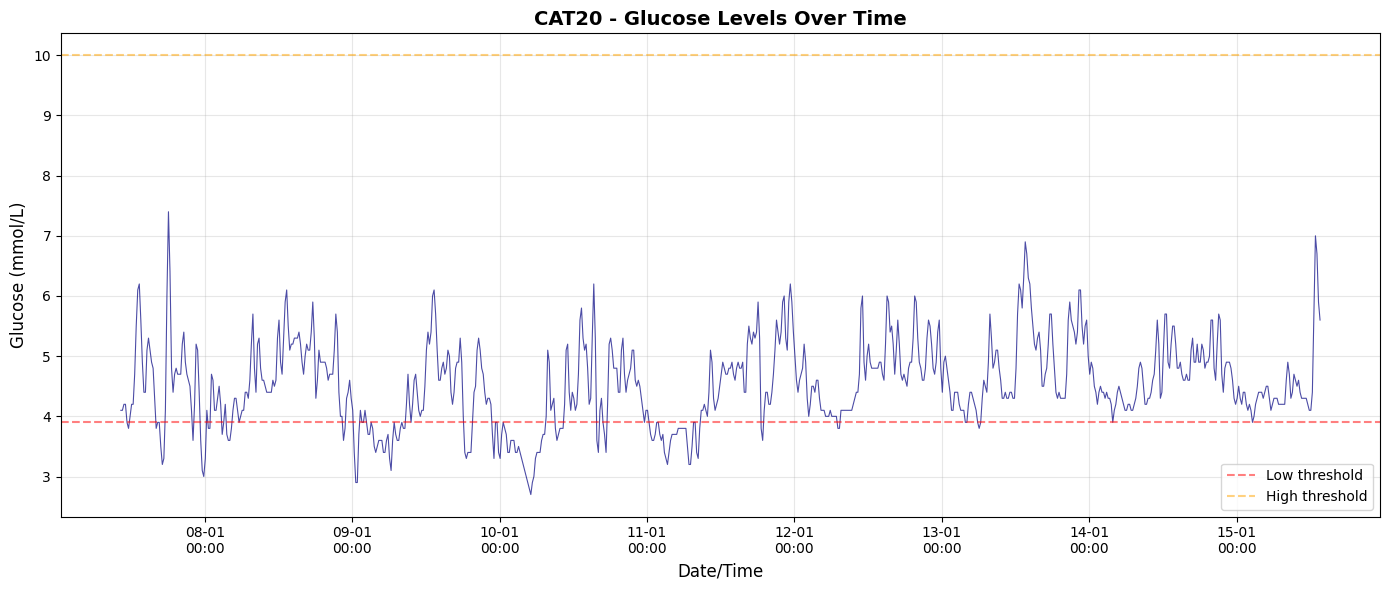

Plotted CAT20


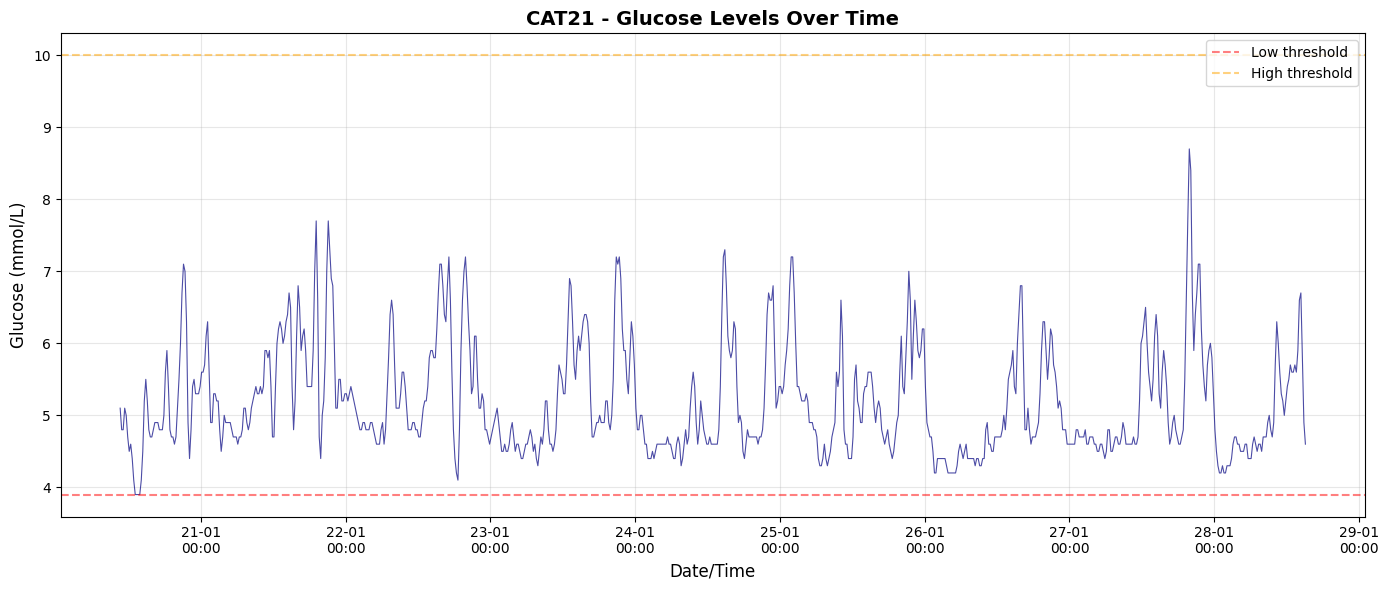

Plotted CAT21


In [117]:
# Plot each patient individually
for patient_id, df in data_dict.items():
    # Extract just the CAT ID (e.g., CAT01 from CAT01WELLCOME_glucose_10-8-2023)
    cat_id = patient_id.split('WELLCOME')[0]
    
    plt.figure(figsize=(14, 6))
    
    plt.plot(df['Device Timestamp'], df['Historic Glucose mmol/L'], 
             color='navy', linewidth=0.8, alpha=0.7)
    
    # Formatting
    plt.xlabel('Date/Time', fontsize=12)
    plt.ylabel('Glucose (mmol/L)', fontsize=12)
    plt.title(f'{cat_id} - Glucose Levels Over Time', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    # Format x-axis to show fewer, cleaner date labels
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m\n%H:%M'))
    plt.xticks(rotation=0)  # No rotation needed now
    
    # Add reference lines (optional - adjust thresholds as needed)
    plt.axhline(y=3.9, color='red', linestyle='--', alpha=0.5, label='Low threshold')
    plt.axhline(y=10.0, color='orange', linestyle='--', alpha=0.5, label='High threshold')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    print(f"Plotted {cat_id}")

In [118]:
summary_stats = {}

for patient_id, df in data_dict.items():
    # Extract just the CAT ID
    cat_id = patient_id.split('WELLCOME')[0]
    
    # Remove NaN values from glucose column
    glucose = df['Historic Glucose mmol/L'].dropna()
    
    # Calculate basic statistics
    stats = {
        'Mean Glucose (mmol/L)': glucose.mean(),
        'Median Glucose (mmol/L)': glucose.median(),
        'Std Dev (mmol/L)': glucose.std(),
        'Min Glucose (mmol/L)': glucose.min(),
        'Max Glucose (mmol/L)': glucose.max(),
        'Range (mmol/L)': glucose.max() - glucose.min(),
        
        # Time in range statistics
        'Time < 3.9 mmol/L (%)': (glucose < 3.9).sum() / len(glucose) * 100,
        'Time 3.9-10.0 mmol/L (%)': ((glucose >= 3.9) & (glucose <= 10.0)).sum() / len(glucose) * 100,
        'Time > 10.0 mmol/L (%)': (glucose > 10.0).sum() / len(glucose) * 100,
        
        # Variability metrics
        'Coefficient of Variation (%)': (glucose.std() / glucose.mean()) * 100,
        
        # Daily change metrics
        'Mean Absolute Change (mmol/L)': glucose.diff().abs().mean(),
        'Mean Change (mmol/L)': glucose.diff().mean(),
        'Max Increase (mmol/L)': glucose.diff().max(),
        'Max Decrease (mmol/L)': glucose.diff().min(),
    }
    
    # Calculate mean daily change (grouping by date)
    df['Date'] = df['Device Timestamp'].dt.date
    daily_means = df.groupby('Date')['Historic Glucose mmol/L'].mean()
    stats['Mean Daily Glucose Change (mmol/L)'] = daily_means.diff().abs().mean()
    
    summary_stats[cat_id] = stats
    
    print(f"\n{'='*60}")
    print(f"{cat_id} - Summary Statistics")
    print(f"{'='*60}")
    for key, value in stats.items():
        print(f"{key:.<45} {value:.2f}")

# Create a summary dataframe
summary_df = pd.DataFrame(summary_stats).T
print(f"\n{'='*60}")
print("Summary Table - All Patients")
print(f"{'='*60}")
print(summary_df.round(2))


CAT01 - Summary Statistics
Mean Glucose (mmol/L)........................ 5.11
Median Glucose (mmol/L)...................... 4.90
Std Dev (mmol/L)............................. 0.76
Min Glucose (mmol/L)......................... 3.70
Max Glucose (mmol/L)......................... 9.60
Range (mmol/L)............................... 5.90
Time < 3.9 mmol/L (%)........................ 1.02
Time 3.9-10.0 mmol/L (%)..................... 98.98
Time > 10.0 mmol/L (%)....................... 0.00
Coefficient of Variation (%)................. 14.92
Mean Absolute Change (mmol/L)................ 0.27
Mean Change (mmol/L)......................... 0.00
Max Increase (mmol/L)........................ 1.70
Max Decrease (mmol/L)........................ -2.00
Mean Daily Glucose Change (mmol/L)........... 0.11

CAT02 - Summary Statistics
Mean Glucose (mmol/L)........................ 5.61
Median Glucose (mmol/L)...................... 5.65
Std Dev (mmol/L)............................. 1.03
Min Glucose (mmol/L)...

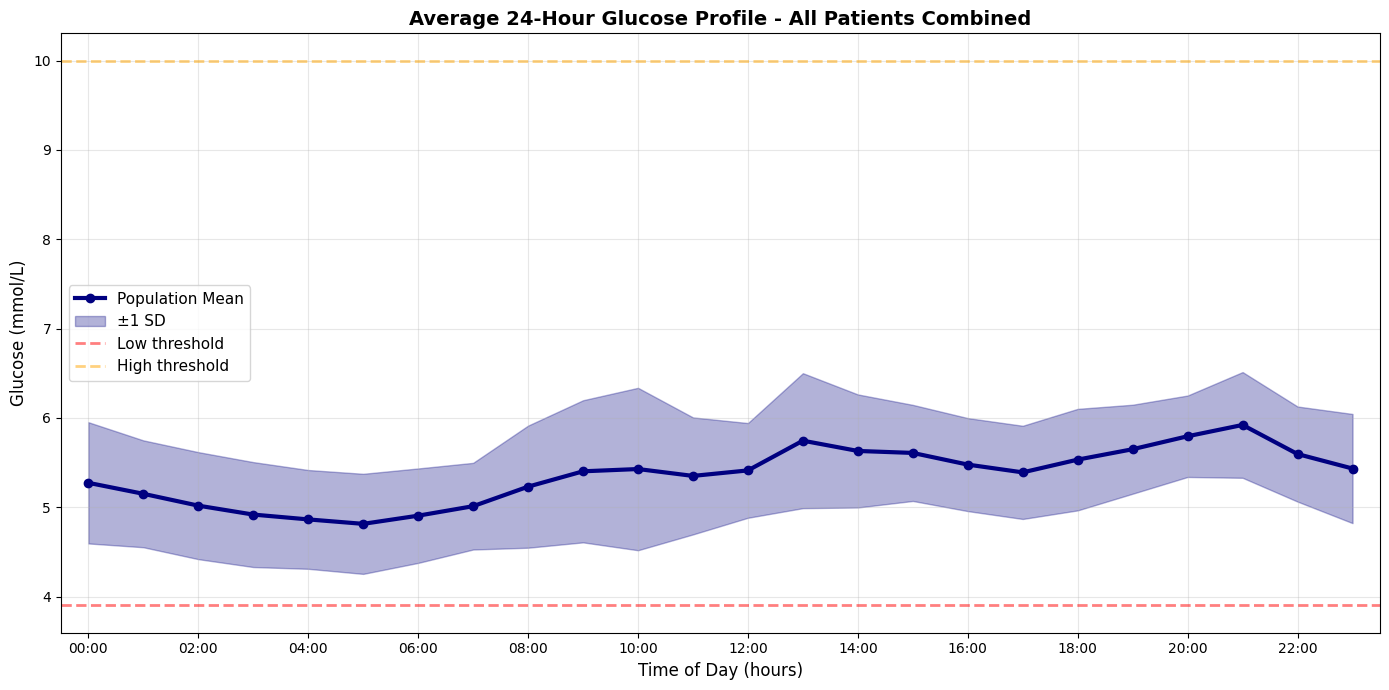


Population Average Glucose by Hour of Day
00:00 - Mean: 5.27 mmol/L, SD: 0.68, N patients: 18
01:00 - Mean: 5.15 mmol/L, SD: 0.60, N patients: 18
02:00 - Mean: 5.02 mmol/L, SD: 0.60, N patients: 18
03:00 - Mean: 4.92 mmol/L, SD: 0.59, N patients: 18
04:00 - Mean: 4.86 mmol/L, SD: 0.55, N patients: 18
05:00 - Mean: 4.81 mmol/L, SD: 0.56, N patients: 18
06:00 - Mean: 4.91 mmol/L, SD: 0.53, N patients: 18
07:00 - Mean: 5.01 mmol/L, SD: 0.49, N patients: 18
08:00 - Mean: 5.23 mmol/L, SD: 0.68, N patients: 18
09:00 - Mean: 5.40 mmol/L, SD: 0.80, N patients: 18
10:00 - Mean: 5.43 mmol/L, SD: 0.91, N patients: 18
11:00 - Mean: 5.35 mmol/L, SD: 0.65, N patients: 18
12:00 - Mean: 5.41 mmol/L, SD: 0.53, N patients: 18
13:00 - Mean: 5.74 mmol/L, SD: 0.76, N patients: 18
14:00 - Mean: 5.63 mmol/L, SD: 0.63, N patients: 18
15:00 - Mean: 5.61 mmol/L, SD: 0.54, N patients: 18
16:00 - Mean: 5.48 mmol/L, SD: 0.52, N patients: 18
17:00 - Mean: 5.39 mmol/L, SD: 0.52, N patients: 18
18:00 - Mean: 5.53 mm

In [119]:
# Calculate average hourly glucose across ALL patients
all_hourly_data = []

for patient_id, df in data_dict.items():
    cat_id = patient_id.split('WELLCOME')[0]
    
    # Extract hour only
    df['Hour_Bin'] = df['Device Timestamp'].dt.hour
    df['Patient_ID'] = cat_id
    
    # Get hourly averages for this patient
    hourly_avg = df.groupby('Hour_Bin')['Historic Glucose mmol/L'].mean().reset_index()
    hourly_avg['Patient_ID'] = cat_id
    
    all_hourly_data.append(hourly_avg)

# Combine all patient data
combined_hourly = pd.concat(all_hourly_data, ignore_index=True)

# Calculate mean and std across all patients for each hour
population_hourly = combined_hourly.groupby('Hour_Bin')['Historic Glucose mmol/L'].agg(['mean', 'std', 'count'])

# Plot
plt.figure(figsize=(14, 7))

# Plot mean line
plt.plot(population_hourly.index, population_hourly['mean'], 
         color='navy', linewidth=3, label='Population Mean', marker='o', markersize=6)

# Add confidence band (±1 SD)
plt.fill_between(population_hourly.index,
                 population_hourly['mean'] - population_hourly['std'],
                 population_hourly['mean'] + population_hourly['std'],
                 alpha=0.3, color='navy', label='±1 SD')

# Formatting
plt.xlabel('Time of Day (hours)', fontsize=12)
plt.ylabel('Glucose (mmol/L)', fontsize=12)
plt.title('Average 24-Hour Glucose Profile - All Patients Combined', fontsize=14, fontweight='bold')
plt.xlim(-0.5, 23.5)
plt.xticks(range(0, 24, 2), [f'{h:02d}:00' for h in range(0, 24, 2)])
plt.grid(True, alpha=0.3)

# Add reference lines
plt.axhline(y=3.9, color='red', linestyle='--', alpha=0.5, linewidth=2, label='Low threshold')
plt.axhline(y=10.0, color='orange', linestyle='--', alpha=0.5, linewidth=2, label='High threshold')
plt.legend(fontsize=11)

plt.tight_layout()
plt.show()

# Print summary
print("\n" + "="*60)
print("Population Average Glucose by Hour of Day")
print("="*60)
for hour in population_hourly.index:
    print(f"{hour:02d}:00 - Mean: {population_hourly.loc[hour, 'mean']:.2f} mmol/L, "
          f"SD: {population_hourly.loc[hour, 'std']:.2f}, "
          f"N patients: {int(population_hourly.loc[hour, 'count'])}")

In [120]:
import sys
!{sys.executable} -m pip install openpyxl

In [121]:
path = '/Users/callumclynes/Documents/GitHub/MDM3-dynamic-therapeutics/Hormones/MD data for Wellcome 2026 January.xlsx'
all_sheets = pd.read_excel(path, sheet_name=None)

print(all_sheets)

{'CAT02':             Unnamed: 0 Unnamed: 1 Unnamed: 2  Metanephrine  Normetanephrine  \
0  2023-08-17 10:01:00      CAT02        A01         0.075            0.085   
1  2023-08-17 10:21:00      CAT02        B01         0.045            0.049   
2  2023-08-17 10:41:00      CAT02        C01         0.024            0.034   
3  2023-08-17 11:01:00      CAT02        D01         0.029            0.051   
4  2023-08-17 11:21:00      CAT02        E01         0.031            0.061   
..                 ...        ...        ...           ...              ...   
76 2023-08-18 11:21:00      CAT02        E10         0.017            0.019   
77 2023-08-18 11:41:00      CAT02        F10         0.014            0.020   
78 2023-08-18 12:01:00      CAT02        G10         0.014            0.020   
79 2023-08-18 12:21:00      CAT02        H10         0.015            0.024   
80 2023-08-18 12:41:00      CAT02        A11         0.017            0.025   

     3-MT  Noradrenaline  Adrenaline  Dop

In [122]:
# Process hormone data to align with glucose data
hormone_dict = {}

for sheet_name, hormone_df in all_sheets.items():
    # Clean up the dataframe
    hormone_df = hormone_df.copy()
    
    # Rename first column to Timestamp
    hormone_df.rename(columns={'Unnamed: 0': 'Timestamp'}, inplace=True)
    
    # Convert timestamp to datetime
    hormone_df['Timestamp'] = pd.to_datetime(hormone_df['Timestamp'])
    
    # Extract CAT ID from sheet name or from data
    cat_id = sheet_name  # e.g., 'CAT02'
    
    # Store in dictionary
    hormone_dict[cat_id] = hormone_df
    
    print(f"✓ Processed {cat_id}: {len(hormone_df)} hormone measurements")

print(f"\nHormone data available for: {list(hormone_dict.keys())}")
print(f"Glucose data available for: {[k.split('WELLCOME')[0] for k in data_dict.keys()]}")

# Find patients with both glucose and hormone data
glucose_patients = set([k.split('WELLCOME')[0] for k in data_dict.keys()])
hormone_patients = set(hormone_dict.keys())
common_patients = glucose_patients.intersection(hormone_patients)

print(f"\nPatients with BOTH glucose and hormone data: {sorted(common_patients)}")

✓ Processed CAT02: 81 hormone measurements
✓ Processed CAT03: 82 hormone measurements
✓ Processed CAT04: 78 hormone measurements
✓ Processed CAT05: 81 hormone measurements
✓ Processed CAT11: 66 hormone measurements
✓ Processed CAT14: 5 hormone measurements

Hormone data available for: ['CAT02', 'CAT03', 'CAT04', 'CAT05', 'CAT11', 'CAT14']
Glucose data available for: ['CAT01', 'CAT02', 'CAT03', 'CAT04Wellcome_glucose_29-9-2023', 'CAT05', 'CAT06', 'CAT07-01', 'CAT10Wellcome_glucose_16-2-2024', 'CAT11', 'CAT12', 'CAT13', 'CAT14', 'CAT15Wellcome_glucose_10-5-2024', 'CAT17', 'CAT18', 'CAT19', 'CAT20', 'CAT21']

Patients with BOTH glucose and hormone data: ['CAT02', 'CAT03', 'CAT05', 'CAT11', 'CAT14']


In [123]:
# Merge glucose and hormone data - only keep glucose data during hormone measurement times
merged_data = {}

for cat_id in sorted(common_patients):
    # Get glucose data
    glucose_key = [k for k in data_dict.keys() if k.startswith(cat_id)][0]
    glucose_df = data_dict[glucose_key].copy()
    
    # Get hormone data and remove any rows with null timestamps
    hormone_df = hormone_dict[cat_id].copy()
    hormone_df = hormone_df.dropna(subset=['Timestamp'])  # Remove null timestamps
    
    # Get the date range where hormone measurements exist
    hormone_start = hormone_df['Timestamp'].min()
    hormone_end = hormone_df['Timestamp'].max()
    
    print(f"\n{cat_id}:")
    print(f"  Hormone measurement period: {hormone_start} to {hormone_end}")
    print(f"  Valid hormone measurements: {len(hormone_df)}")
    
    # Filter glucose data to only this period
    glucose_filtered = glucose_df[
        (glucose_df['Device Timestamp'] >= hormone_start) & 
        (glucose_df['Device Timestamp'] <= hormone_end)
    ].copy()
    
    # Remove any null timestamps from glucose data too
    glucose_filtered = glucose_filtered.dropna(subset=['Device Timestamp'])
    
    print(f"  Original glucose readings: {len(glucose_df)}")
    print(f"  Filtered glucose readings: {len(glucose_filtered)}")
    
    # Merge on nearest timestamp (within 2 minutes)
    merged = pd.merge_asof(
        glucose_filtered.sort_values('Device Timestamp'),
        hormone_df.sort_values('Timestamp'),
        left_on='Device Timestamp',
        right_on='Timestamp',
        direction='nearest',
        tolerance=pd.Timedelta('2min')
    )
    
    # Store merged data
    merged_data[cat_id] = merged
    
    print(f"  Merged rows: {len(merged)}")
    print(f"  Rows with hormone data: {merged['Metanephrine'].notna().sum()}")
    
    # Show column names
    if cat_id == sorted(common_patients)[0]:  # Only show for first patient
        print(f"\nAvailable columns in merged data:")
        for col in merged.columns:
            print(f"  - {col}")

print("\n" + "="*60)
print("Summary of Merged Datasets")
print("="*60)
for cat_id, df in merged_data.items():
    print(f"{cat_id}: {len(df)} glucose readings, {df['Metanephrine'].notna().sum()} with hormone data")

# Preview first merged dataset
if merged_data:
    first_cat = sorted(common_patients)[0]
    print(f"\nPreview of {first_cat} merged data:")
    print(merged_data[first_cat][['Device Timestamp', 'Historic Glucose mmol/L', 
                                   'Metanephrine', 'Normetanephrine', 'Cortisol']].head(10))


CAT02:
  Hormone measurement period: 2023-08-17 10:01:00 to 2023-08-18 12:41:00
  Valid hormone measurements: 81
  Original glucose readings: 686
  Filtered glucose readings: 106
  Merged rows: 106
  Rows with hormone data: 26

Available columns in merged data:
  - Device
  - Serial Number
  - Device Timestamp
  - Record Type
  - Historic Glucose mmol/L
  - Scan Glucose mmol/L
  - Non-numeric Rapid-Acting Insulin
  - Rapid-Acting Insulin (units)
  - Non-numeric Food
  - Carbohydrates (grams)
  - Carbohydrates (servings)
  - Non-numeric Long-Acting Insulin
  - Long-Acting Insulin Value (units)
  - Notes
  - Strip Glucose mmol/L
  - Ketone mmol/L
  - Meal Insulin (units)
  - Correction Insulin (units)
  - User Change Insulin (units)
  - Date
  - Hour_Bin
  - Patient_ID
  - Timestamp
  - Unnamed: 1
  - Unnamed: 2
  - Metanephrine
  - Normetanephrine
  - 3-MT
  - Noradrenaline
  - Adrenaline
  - Dopamine
  - LDOPA
  - 3-OMD
  - DOPAC
  - Dopeg
  - Melatonin
  - 18-OH-cortisol
  - Cortisol

In [124]:
# Analyze correlations for all patients except CAT14
patients_to_analyze = [cat for cat in sorted(common_patients) if cat != 'CAT14']

print("="*70)
print("CORRELATION ANALYSIS: Glucose vs Hormones")
print("="*70)

# Store all correlations
all_correlations = {}

for cat_id in patients_to_analyze:
    # Get data with hormone measurements
    with_hormones = merged_data[cat_id][merged_data[cat_id]['Metanephrine'].notna()].copy()
    
    # Verify data quality
    print(f"\n{cat_id}:")
    print(f"  Total merged rows: {len(merged_data[cat_id])}")
    print(f"  Rows with hormone data: {len(with_hormones)}")
    print(f"  Glucose NaNs in hormone rows: {with_hormones['Historic Glucose mmol/L'].isna().sum()}")
    
    # Define hormone columns
    hormone_cols = ['Metanephrine', 'Normetanephrine', 'Adrenaline', 'Noradrenaline', 
                    'Dopamine', 'Cortisol', 'Cortisone', '3-MT', 'LDOPA', '3-OMD', 
                    'DOPAC', 'Dopeg', 'Melatonin', '18-OH-cortisol']
    
    # Calculate correlations
    correlations = {}
    print(f"\n{cat_id} (n={len(with_hormones)} measurements):")
    print("-" * 70)
    
    for hormone in hormone_cols:
        if hormone in with_hormones.columns:
            # Remove NaN values for correlation calculation
            valid_data = with_hormones[['Historic Glucose mmol/L', hormone]].dropna()
            if len(valid_data) > 2:  # Need at least 3 points for correlation
                corr = valid_data['Historic Glucose mmol/L'].corr(valid_data[hormone])
                correlations[hormone] = corr
                print(f"  {hormone:.<35} r = {corr:>7.3f} (n={len(valid_data)})")
    
    all_correlations[cat_id] = correlations

# Create summary dataframe
corr_df = pd.DataFrame(all_correlations).T
print("\n" + "="*70)
print("SUMMARY: Correlations Across All Patients")
print("="*70)
print(corr_df.round(3))

# Calculate mean correlations across patients
print("\n" + "="*70)
print("MEAN CORRELATIONS (Across All Patients)")
print("="*70)
mean_corr = corr_df.mean().sort_values(ascending=False)
for hormone, corr in mean_corr.items():
    print(f"{hormone:.<35} Mean r = {corr:>7.3f}")

CORRELATION ANALYSIS: Glucose vs Hormones

CAT02:
  Total merged rows: 106
  Rows with hormone data: 26
  Glucose NaNs in hormone rows: 0

CAT02 (n=26 measurements):
----------------------------------------------------------------------
  Metanephrine....................... r =  -0.154 (n=26)
  Normetanephrine.................... r =   0.144 (n=26)
  Adrenaline......................... r =   0.064 (n=26)
  Noradrenaline...................... r =   0.083 (n=26)
  Dopamine........................... r =   0.082 (n=26)
  Cortisol........................... r =  -0.296 (n=26)
  Cortisone.......................... r =  -0.280 (n=26)
  3-MT............................... r =   0.117 (n=26)
  LDOPA.............................. r =   0.113 (n=26)
  3-OMD.............................. r =  -0.231 (n=26)
  DOPAC.............................. r =   0.084 (n=26)
  Dopeg.............................. r =   0.101 (n=26)
  Melatonin.......................... r =  -0.389 (n=13)
  18-OH-cortisol......

/Users/callumclynes/Desktop/miniconda3/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/callumclynes/Desktop/miniconda3/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


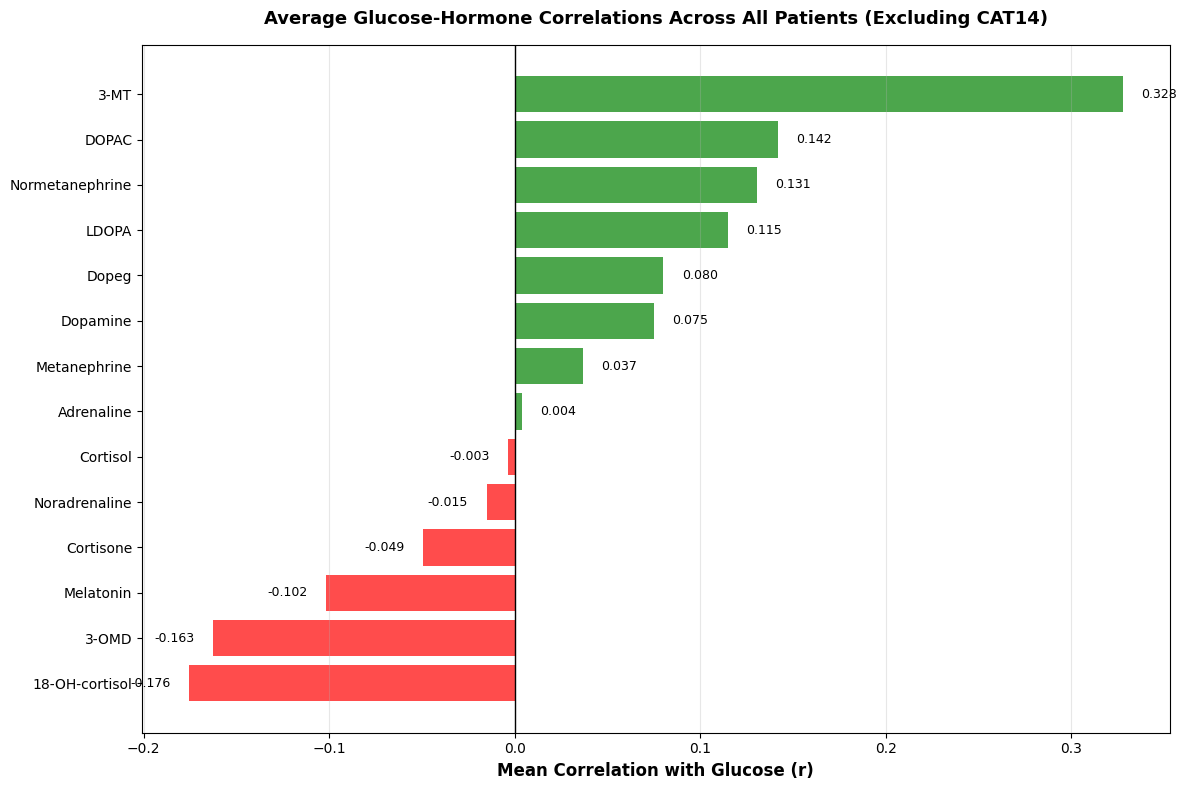


KEY FINDINGS:

Strongest POSITIVE correlations (glucose increases with hormone):
  1. 3-MT (3-Methoxytyramine)........ r = 0.328
  2. DOPAC (Dopamine metabolite)..... r = 0.142
  3. Normetanephrine................. r = 0.131

Strongest NEGATIVE correlations (glucose decreases with hormone):
  1. 18-OH-cortisol.................. r = -0.176
  2. 3-OMD............................ r = -0.163
  3. Melatonin........................ r = -0.102

Nearly ZERO correlation (no relationship):
  - Adrenaline........................ r = 0.004
  - Cortisol.......................... r = -0.003
  - Noradrenaline..................... r = -0.015


In [125]:
# Create a bar plot of mean correlations
fig, ax = plt.subplots(figsize=(12, 8))

# Sort by correlation value
mean_corr_sorted = mean_corr.sort_values(ascending=True)

# Create colors: positive = green, negative = red
colors = ['green' if x > 0 else 'red' for x in mean_corr_sorted.values]

# Create horizontal bar plot
bars = ax.barh(range(len(mean_corr_sorted)), mean_corr_sorted.values, color=colors, alpha=0.7)

# Add vertical line at zero
ax.axvline(x=0, color='black', linestyle='-', linewidth=1)

# Labels and formatting
ax.set_yticks(range(len(mean_corr_sorted)))
ax.set_yticklabels(mean_corr_sorted.index, fontsize=10)
ax.set_xlabel('Mean Correlation with Glucose (r)', fontsize=12, fontweight='bold')
ax.set_title('Average Glucose-Hormone Correlations Across All Patients (Excluding CAT14)', 
             fontsize=13, fontweight='bold', pad=15)
ax.grid(True, alpha=0.3, axis='x')

# Add value labels on bars
for i, (hormone, value) in enumerate(mean_corr_sorted.items()):
    ax.text(value + 0.01 if value > 0 else value - 0.01, i, f'{value:.3f}', 
            va='center', ha='left' if value > 0 else 'right', fontsize=9)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("KEY FINDINGS:")
print("="*70)
print(f"\nStrongest POSITIVE correlations (glucose increases with hormone):")
print(f"  1. 3-MT (3-Methoxytyramine)........ r = {mean_corr['3-MT']:.3f}")
print(f"  2. DOPAC (Dopamine metabolite)..... r = {mean_corr['DOPAC']:.3f}")
print(f"  3. Normetanephrine................. r = {mean_corr['Normetanephrine']:.3f}")

print(f"\nStrongest NEGATIVE correlations (glucose decreases with hormone):")
print(f"  1. 18-OH-cortisol.................. r = {mean_corr['18-OH-cortisol']:.3f}")
print(f"  2. 3-OMD............................ r = {mean_corr['3-OMD']:.3f}")
print(f"  3. Melatonin........................ r = {mean_corr['Melatonin']:.3f}")

print(f"\nNearly ZERO correlation (no relationship):")
print(f"  - Adrenaline........................ r = {mean_corr['Adrenaline']:.3f}")
print(f"  - Cortisol.......................... r = {mean_corr['Cortisol']:.3f}")
print(f"  - Noradrenaline..................... r = {mean_corr['Noradrenaline']:.3f}")

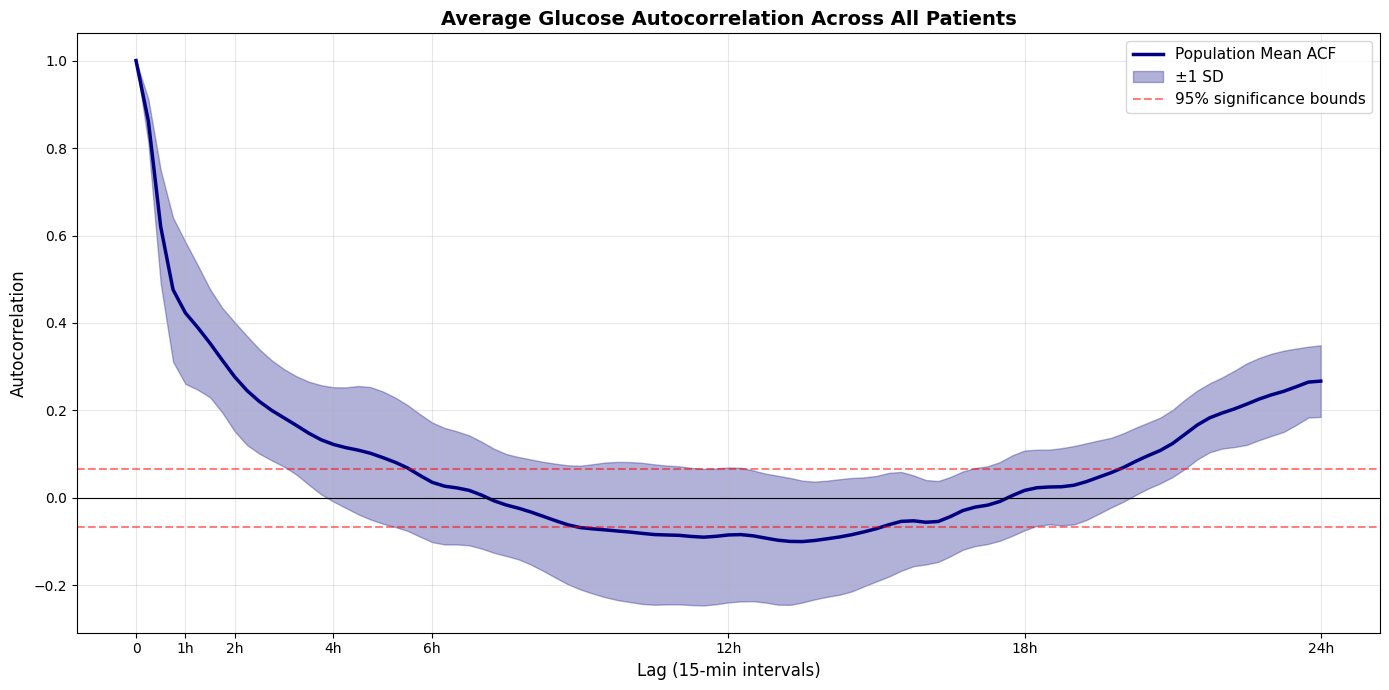

AUTOCORRELATION SUMMARY
Number of patients: 18
Average sample size per patient: 877 readings

ACF at key lags:
  Lag 4 (1 hour)........ Mean ACF = 0.423 ± 0.162
  Lag 8 (2 hours)....... Mean ACF = 0.277 ± 0.125
  Lag 16 (4 hours)...... Mean ACF = 0.122 ± 0.131
  Lag 24 (6 hours)...... Mean ACF = 0.036 ± 0.137
  Lag 48 (12 hours)..... Mean ACF = -0.085 ± 0.154
  Lag 96 (24 hours)..... Mean ACF = 0.267 ± 0.082

ACF drops below 0.5 at lag 3 (45 minutes = 0.8 hours)


In [126]:
from statsmodels.tsa.stattools import acf

# Calculate ACF for all patients
all_acf = {}
max_lags = 96  # 24 hours (at 15-min intervals)

for patient_key in data_dict.keys():
    cat_id = patient_key.split('WELLCOME')[0]
    glucose = data_dict[patient_key]['Historic Glucose mmol/L'].dropna()
    
    # Calculate ACF values
    acf_values = acf(glucose, nlags=max_lags, fft=True)
    all_acf[cat_id] = acf_values

# Convert to array for easier manipulation
acf_array = np.array(list(all_acf.values()))  # Shape: (n_patients, max_lags+1)

# Calculate mean and std across patients
mean_acf = np.mean(acf_array, axis=0)
std_acf = np.std(acf_array, axis=0)
sem_acf = std_acf / np.sqrt(len(all_acf))  # Standard error of mean

# Create plot
plt.figure(figsize=(14, 7))

# Plot mean ACF
lags = np.arange(len(mean_acf))
plt.plot(lags, mean_acf, color='navy', linewidth=2.5, label='Population Mean ACF')

# Add confidence band (±1 SD)
plt.fill_between(lags, mean_acf - std_acf, mean_acf + std_acf, 
                 alpha=0.3, color='navy', label='±1 SD')

# Alternative: use ±1.96 SEM for 95% CI of the mean
# plt.fill_between(lags, mean_acf - 1.96*sem_acf, mean_acf + 1.96*sem_acf, 
#                  alpha=0.3, color='navy', label='95% CI')

# Add reference lines
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.8)

# Add approximate significance bounds (using average sample size)
avg_n = np.mean([len(data_dict[k]['Historic Glucose mmol/L'].dropna()) for k in data_dict.keys()])
conf_interval = 1.96 / np.sqrt(avg_n)
plt.axhline(y=conf_interval, color='red', linestyle='--', alpha=0.5, label='95% significance bounds')
plt.axhline(y=-conf_interval, color='red', linestyle='--', alpha=0.5)

# Formatting
plt.xlabel('Lag (15-min intervals)', fontsize=12)
plt.ylabel('Autocorrelation', fontsize=12)
plt.title('Average Glucose Autocorrelation Across All Patients', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)

# Add x-axis labels in hours for easier interpretation
ax = plt.gca()
hour_ticks = [0, 4, 8, 16, 24, 48, 72, 96]  # 0, 1h, 2h, 4h, 6h, 12h, 18h, 24h
hour_labels = ['0', '1h', '2h', '4h', '6h', '12h', '18h', '24h']
ax.set_xticks(hour_ticks)
ax.set_xticklabels(hour_labels)

plt.tight_layout()
plt.show()

# Print summary statistics
print("="*70)
print("AUTOCORRELATION SUMMARY")
print("="*70)
print(f"Number of patients: {len(all_acf)}")
print(f"Average sample size per patient: {avg_n:.0f} readings")
print(f"\nACF at key lags:")
print(f"  Lag 4 (1 hour)........ Mean ACF = {mean_acf[4]:.3f} ± {std_acf[4]:.3f}")
print(f"  Lag 8 (2 hours)....... Mean ACF = {mean_acf[8]:.3f} ± {std_acf[8]:.3f}")
print(f"  Lag 16 (4 hours)...... Mean ACF = {mean_acf[16]:.3f} ± {std_acf[16]:.3f}")
print(f"  Lag 24 (6 hours)...... Mean ACF = {mean_acf[24]:.3f} ± {std_acf[24]:.3f}")
print(f"  Lag 48 (12 hours)..... Mean ACF = {mean_acf[48]:.3f} ± {std_acf[48]:.3f}")
print(f"  Lag 96 (24 hours)..... Mean ACF = {mean_acf[96]:.3f} ± {std_acf[96]:.3f}")

# Find lag where ACF drops below 0.5 on average
lag_50 = np.argmax(mean_acf < 0.5)
print(f"\nACF drops below 0.5 at lag {lag_50} ({lag_50*15} minutes = {lag_50/4:.1f} hours)")

In [127]:
act = pd.read_excel(Path('updated_activity_labels_2 (1).xlsx'))

print(act.head())

   sampling_id       date  activity_number         description  intensity  \
0            1 2023-08-09                1     At the computer        0.0   
1            1 2023-08-09                2            Scooting        1.0   
2            1 2023-08-09                3  Walking and stairs        1.0   
3            1 2023-08-09                4        sitting down        0.0   
4            1 2023-08-09                5             walking        1.0   

   minutes time_of_day  activity_label  
0     10.0       11:30             sit  
1     10.0       11:40  light_activity  
2      5.0       11:45  light_activity  
3    100.0       11:50             sit  
4     45.0       13:30  light_activity  


In [128]:
act["date"] = pd.to_datetime(act["date"], errors="coerce")

# start = date + time_of_day
act["start"] = pd.to_datetime(
    act["date"].dt.strftime("%Y-%m-%d") + " " + act["time_of_day"].astype(str),
    errors="coerce"
)

act["minutes"] = pd.to_numeric(act["minutes"], errors="coerce")
act["end"] = act["start"] + pd.to_timedelta(act["minutes"], unit="m")

# CAT label from sampling_id (1 -> CAT01)
act["CAT"] = ("CAT" + act["sampling_id"].astype(str).str.zfill(2)).astype(str).str.strip()

# keep only usable rows
act = act.dropna(subset=["CAT", "start", "end", "activity_label"]).copy()
act["start"] = pd.to_datetime(act["start"], errors="coerce")
act["end"]   = pd.to_datetime(act["end"], errors="coerce")
act = act.dropna(subset=["start", "end"]).copy()
act=act.drop(columns=["sampling_id"])
act["activity_label"].value_counts(normalize=False)


activity_label
sit                  127
light_activity       102
stand                 51
lying                 25
moderate_activity     18
Name: count, dtype: int64